# Importing Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np
import splitfolders
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
import math
from tensorflow.keras import layers, Model, models
import tensorflow.keras.backend as K
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D,Dropout,MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [3]:
class config:
    
    data_path = 'Multi Cancer/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [4]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

In [5]:
BATCH_SIZE = 64
IMAGE_SHAPE = (224, 224)
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 104000 images belonging to 26 classes.
Found 26002 images belonging to 26 classes.


In [7]:
class_map = dict([(v, k) for k, v in train_gen.class_indices.items()])
print(class_map)

{0: 'all_benign', 1: 'all_early', 2: 'all_pre', 3: 'all_pro', 4: 'brain_glioma', 5: 'brain_menin', 6: 'brain_tumor', 7: 'breast_benign', 8: 'breast_malignant', 9: 'cervix_dyk', 10: 'cervix_koc', 11: 'cervix_mep', 12: 'cervix_pab', 13: 'cervix_sfi', 14: 'colon_aca', 15: 'colon_bnt', 16: 'kidney_normal', 17: 'kidney_tumor', 18: 'lung_aca', 19: 'lung_bnt', 20: 'lung_scc', 21: 'lymph_cll', 22: 'lymph_fl', 23: 'lymph_mcl', 24: 'oral_normal', 25: 'oral_scc'}


# Data visualization

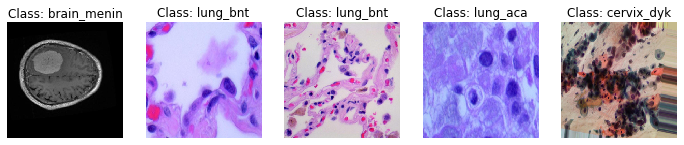

In [8]:
class_names = list(train_gen.class_indices.keys())


sample_images, sample_labels = train_gen.next()


num_images_to_display = 5


plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(sample_images[i])
    
    
    label_index = np.argmax(sample_labels[i])
    class_name = class_names[label_index]
    
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.show()

# Applying Algorithm

In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

# VGG16

In [10]:
activation_function = 'relu'
num_neurons = 128
num_epochs = 100
batch_size = 32
learning_rate = 1e-4


base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(num_neurons, activation=activation_function)(x)
predictions = Dense(26, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])


model.summary()


early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=num_epochs, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

1625/1625 [==============================] - 195s 120ms/step - loss: 0.0203 - accuracy: 0.9946 - f1_score: 0.9945 - recall_m: 0.9940 - precision_m: 0.9949 - specificity_m: 0.9998 - sensitivity_m: 0.9940 - mae: 0.0012 - mse: 3.6404e-04 - val_loss: 0.0874 - val_accuracy: 0.9694 - val_f1_score: 0.9697 - val_recall_m: 0.9687 - val_precision_m: 0.9707 - val_specificity_m: 0.9988 - val_sensitivity_m: 0.9687 - val_mae: 0.0032 - val_mse: 0.0018
Epoch 12/100
1625/1625 [==============================] - 195s 120ms/step - loss: 0.0176 - accuracy: 0.9951 - f1_score: 0.9951 - recall_m: 0.9947 - precision_m: 0.9954 - specificity_m: 0.9998 - sensitivity_m: 0.9947 - mae: 0.0010 - mse: 3.1697e-04 - val_loss: 0.1018 - val_accuracy: 0.9655 - val_f1_score: 0.9656 - val_recall_m: 0.9647 - val_precision_m: 0.9665 - val_specificity_m: 0.9987 - val_sensitivity_m: 0.9647 - val_mae: 0.0034 - val_mse: 0.0020


In [11]:
model.save('models/vgg16.h5')

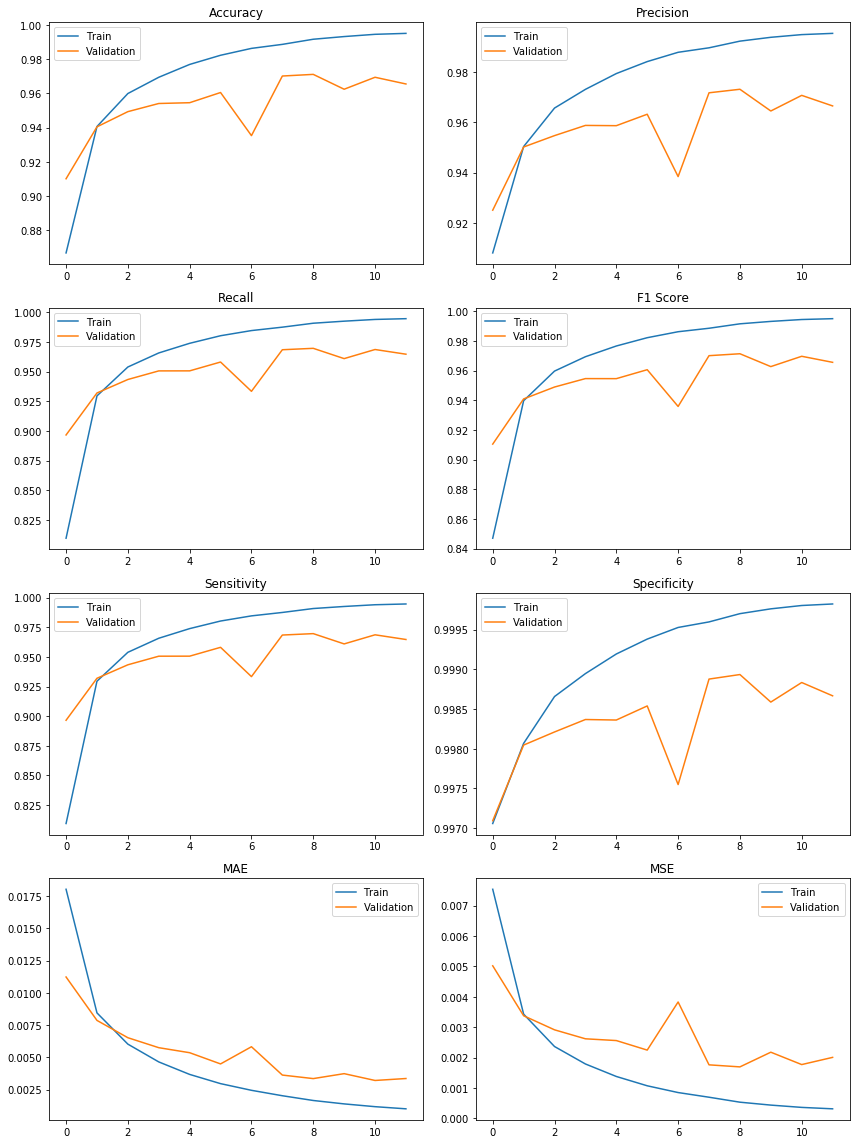

In [12]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

407/407 [==============================] - 39s 96ms/step - loss: 0.1018 - accuracy: 0.9655 - f1_score: 0.9656 - recall_m: 0.9647 - precision_m: 0.9665 - specificity_m: 0.9987 - sensitivity_m: 0.9647 - mae: 0.0034 - mse: 0.0020


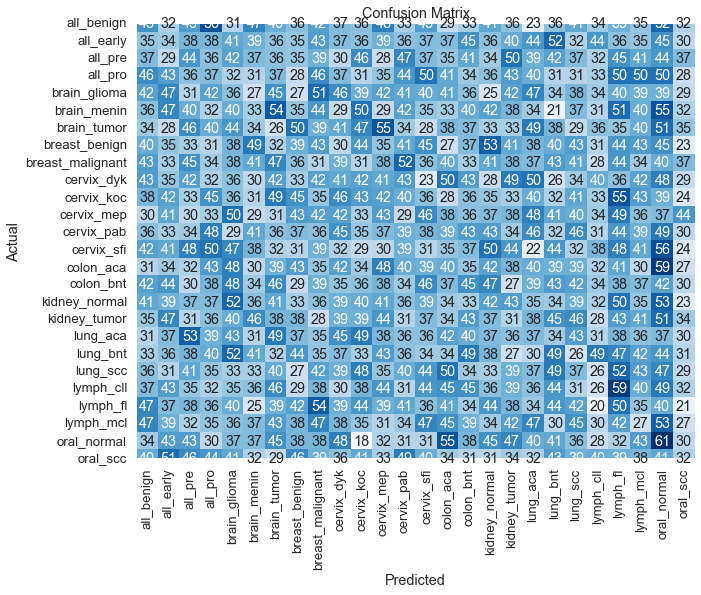

In [13]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 99.51057434082031
Precision = 99.5438277721405
F1 Score = 99.50560331344604
Recall = 99.46826696395874
MAE = 0.0010100568179041147
MSE = 0.00031696795485913754
Sensitivity = 99.46826696395874
Specificity = 99.98213052749634


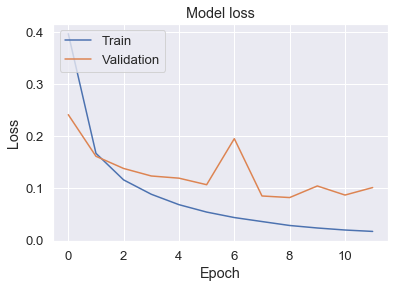

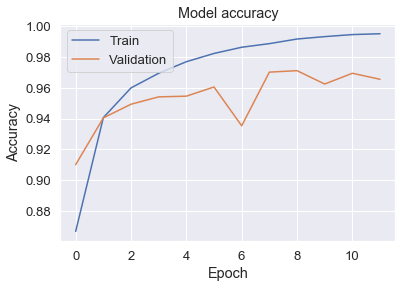

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# VGG19

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [17]:
activation_function = LeakyReLU(alpha=0.2)
num_neurons = 64
num_epochs = 125
batch_size = 32
learning_rate = 1e-3

# Load VGG19 model without the top classification layer
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(num_neurons, activation=activation_function)(x)
predictions = Dense(26, activation='softmax')(x)

# Combine the base model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])


model.summary()


early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=num_epochs, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
model.save('models/vgg19.h5')

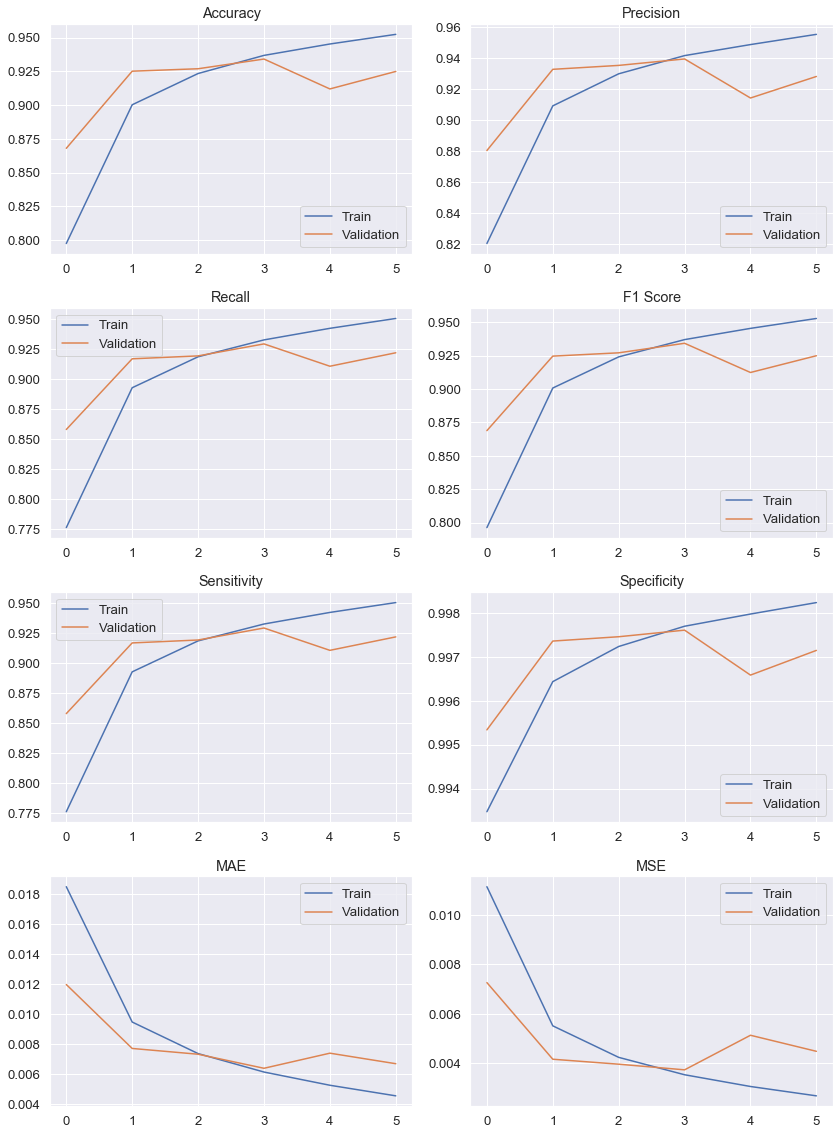

In [19]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

407/407 [==============================] - 40s 97ms/step - loss: 0.2522 - accuracy: 0.9249 - f1_score: 0.9247 - recall_m: 0.9214 - precision_m: 0.9279 - specificity_m: 0.9971 - sensitivity_m: 0.9214 - mae: 0.0067 - mse: 0.0045


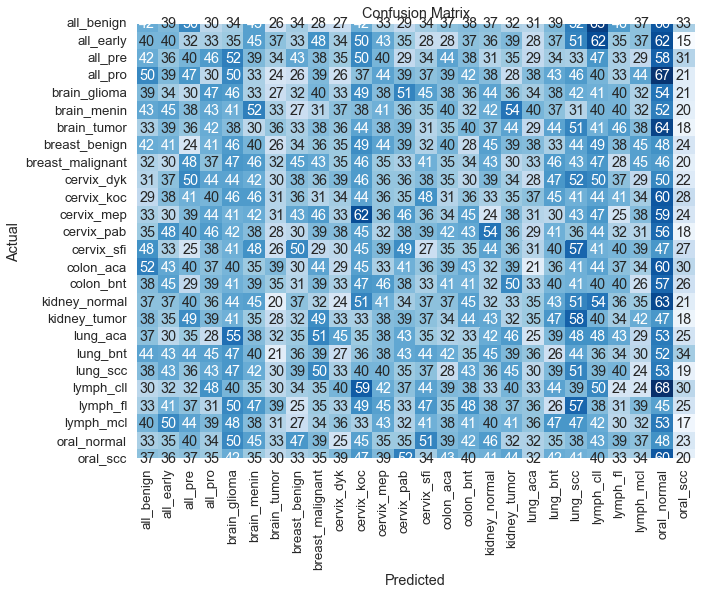

In [20]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 95.24134397506714
Precision = 95.53141593933105
F1 Score = 95.27313113212585
Recall = 95.02115249633789
MAE = 0.004551942925900221
MSE = 0.00268198037520051
Sensitivity = 95.02115249633789
Specificity = 99.82335567474365


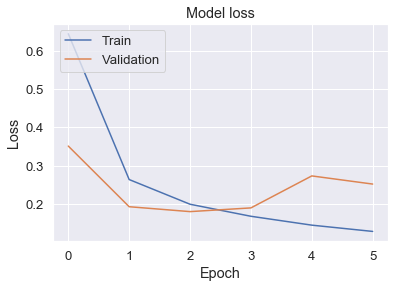

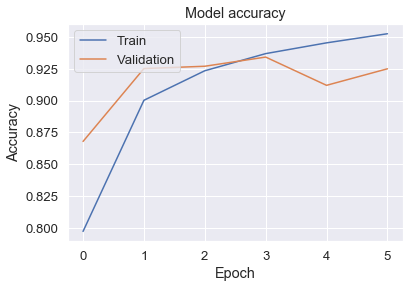

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Densenet201

In [23]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [24]:
activation_function = 'tanh'
num_neurons = 128
num_epochs = 150
batch_size = 128
learning_rate = 1e-3

# Load DenseNet201 model with the top classification layer
base_model = tf.keras.applications.densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(num_neurons, activation=activation_function)(x)
predictions = Dense(26, activation='softmax')(x)

# Combine the base model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])

# Print model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=num_epochs, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/150
1625/1625 [==============================] - 351s 209ms/step - loss: 0.2328 - accuracy: 0.9125 - f1_score: 0.9116 - recall_m: 0.9032 - precision_m: 0.9210 - specificity_m: 0.9970 - sensitivity_m: 0.9032 - mae: 0.0096 - mse: 0.0048 - val_loss: 0.4294 - val_accuracy: 0.8663 - val_f1_score: 0.8673 - val_recall_m: 0.8595 - val_precision_m: 0.8754 - val_specificity_m: 0.9951 - val_sensitivity_m: 0.8595 - val_mae: 0.0123 - val_mse: 0.0079
Epoch 2/150
1625/1625 [==============================] - 337s 207ms/step - loss: 0.1012 - accuracy: 0.9638 - f1_score: 0.9637 - recall_m: 0.9620 - precision_m: 0.9654 - specificity_m: 0.9986 - sensitivity_m: 0.9620 - mae: 0.0042 - mse: 0.0021 - val_loss: 0.5124 - val_accuracy: 0.8327 - val_f1_score: 0.8330 - val_recall_m: 0.8200 - val_precision_m: 0.8467 - val_specificity_m: 0.9941 - val_sensitivity_m: 0.8200 - val_mae: 0.0154 - val_mse: 0.0098
Epoch 3/150
1625/1625 [==============================] - 337s 207ms/step - loss: 0.0749 - accuracy: 0.

In [25]:
model.save('models/densenet201.h5')

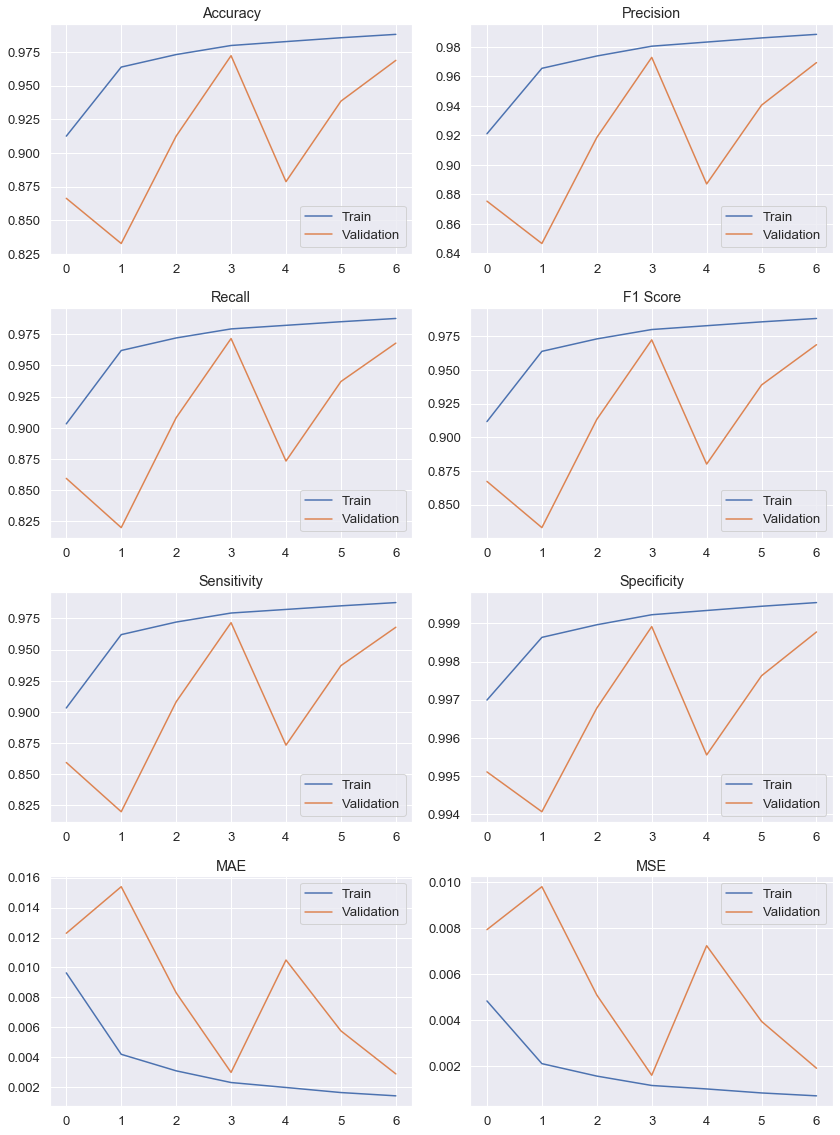

In [26]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

407/407 [==============================] - 41s 100ms/step - loss: 0.1047 - accuracy: 0.9688 - f1_score: 0.9687 - recall_m: 0.9680 - precision_m: 0.9694 - specificity_m: 0.9988 - sensitivity_m: 0.9680 - mae: 0.0029 - mse: 0.0019


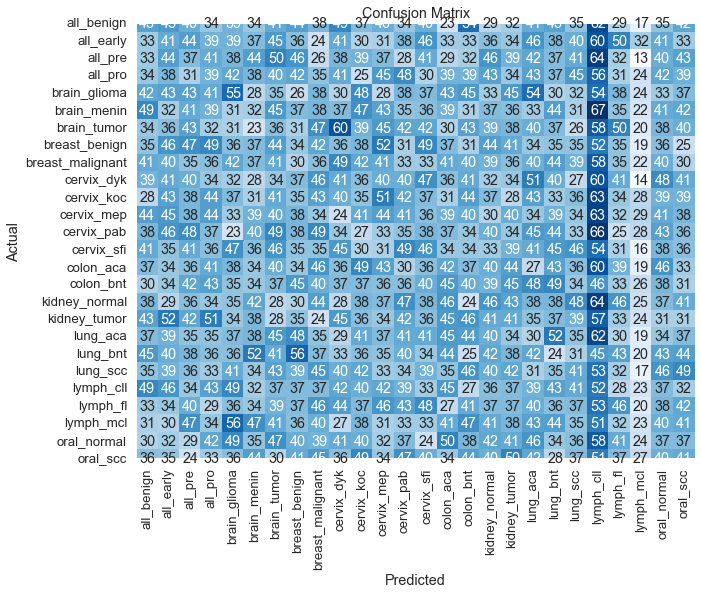

In [27]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 98.80961775779724
Precision = 98.84238243103027
F1 Score = 98.80686402320862
Recall = 98.77211451530457
MAE = 0.001421698252670467
MSE = 0.0007155073690228164
Sensitivity = 98.77211451530457
Specificity = 99.95450973510742


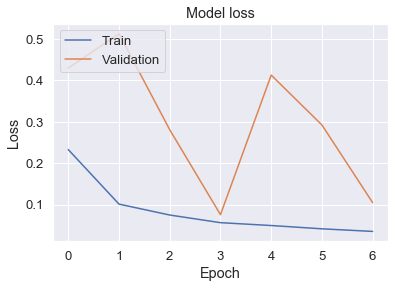

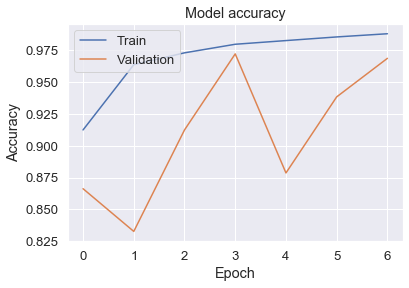

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MobileNetV3-SMALL

In [30]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [31]:

activation_function = 'relu'
num_neurons = 256
num_epochs = 100
batch_size = 128
learning_rate = 1e-4

# Load MobileNetV3 Small model with the top classification layer
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(num_neurons, activation=activation_function)(x)
predictions = Dense(26, activation='softmax')(x)

# Combine the base model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])

# Print model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=num_epochs, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

1625/1625 [==============================] - 213s 129ms/step - loss: 0.3017 - accuracy: 0.8938 - f1_score: 0.8801 - recall_m: 0.8642 - precision_m: 0.9082 - specificity_m: 0.9973 - sensitivity_m: 0.8642 - mae: 0.0125 - mse: 0.0058 - val_loss: 3.9794 - val_accuracy: 0.0118 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 0.9999 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.0741 - val_mse: 0.0400
Epoch 2/100
1625/1625 [==============================] - 210s 129ms/step - loss: 0.0698 - accuracy: 0.9746 - f1_score: 0.9746 - recall_m: 0.9736 - precision_m: 0.9756 - specificity_m: 0.9990 - sensitivity_m: 0.9736 - mae: 0.0032 - mse: 0.0015 - val_loss: 6.1829 - val_accuracy: 0.0785 - val_f1_score: 0.0640 - val_recall_m: 0.0571 - val_precision_m: 0.0732 - val_specificity_m: 0.9710 - val_sensitivity_m: 0.0571 - val_mae: 0.0714 - val_mse: 0.0538
Epoch 3/100
1625/1625 [==============================] - 207s 127ms/step - loss: 0.0382 - accuracy

In [32]:
model.save('models/mobilenetv3_small.h5')

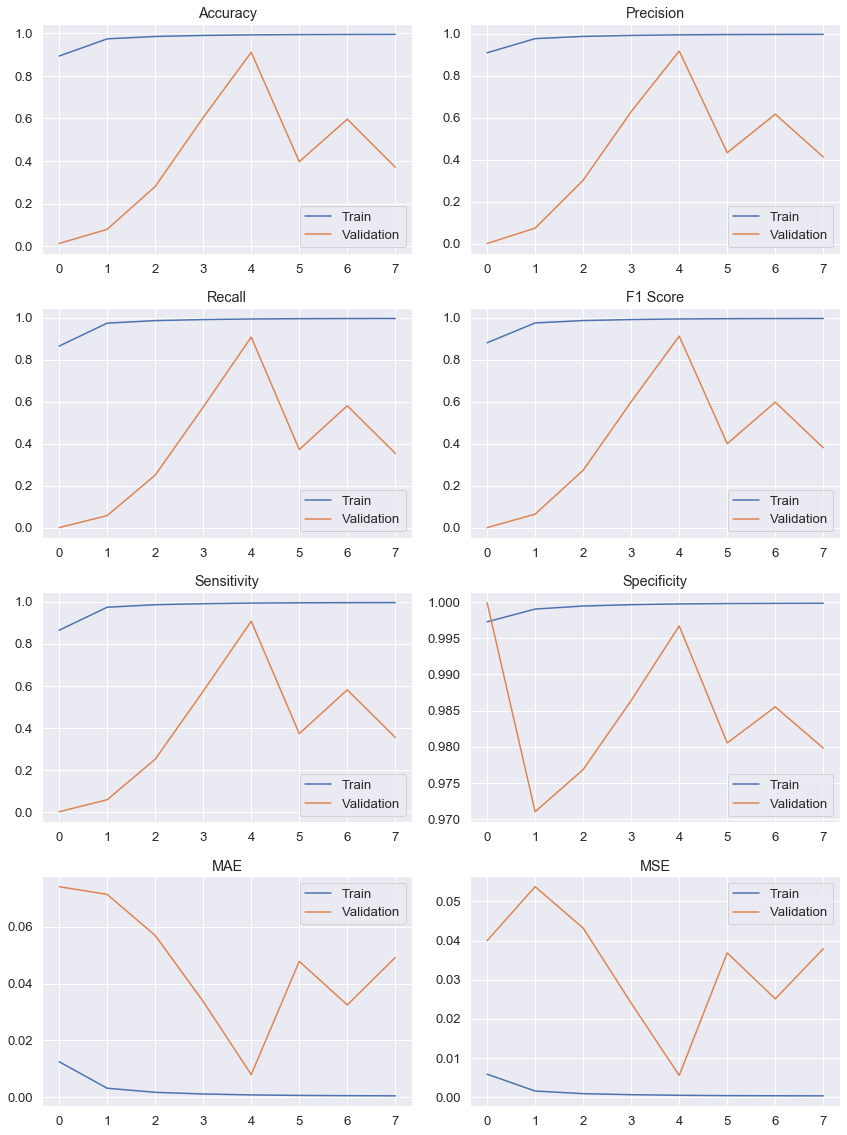

In [33]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

407/407 [==============================] - 43s 105ms/step - loss: 3.6281 - accuracy: 0.3708 - f1_score: 0.3807 - recall_m: 0.3539 - precision_m: 0.4124 - specificity_m: 0.9798 - sensitivity_m: 0.3539 - mae: 0.0492 - mse: 0.0379


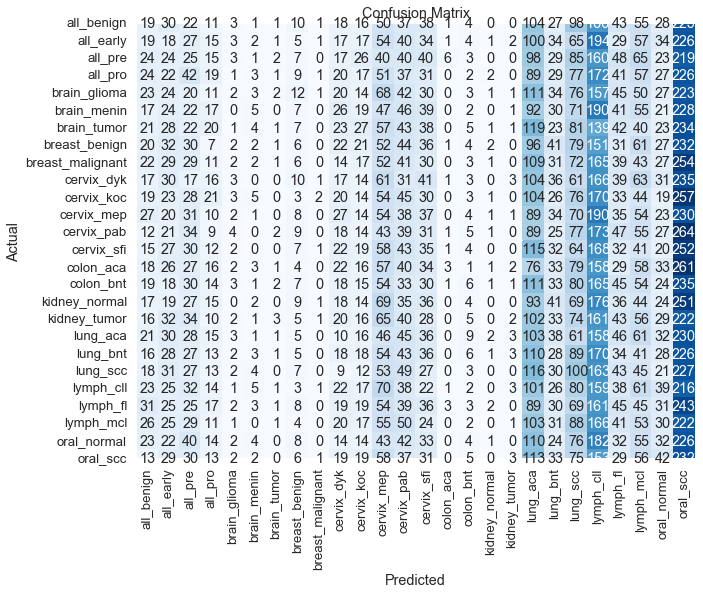

In [34]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [35]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.58269000053406
Precision = 99.59419965744019
F1 Score = 99.58547353744507
Recall = 99.5769202709198
MAE = 0.00048187357606366277
MSE = 0.00024725974071770906
Sensitivity = 99.5769202709198
Specificity = 99.98407363891602


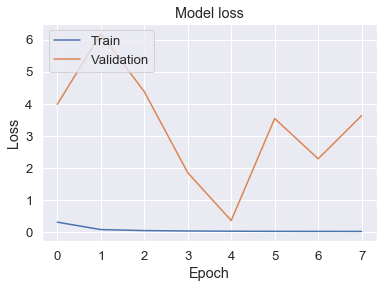

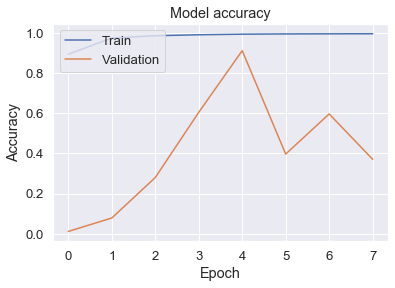

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# MobileNetV3-Large

In [37]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [38]:
activation_function = 'relu'
num_neurons = 257
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

# Load MobileNetV3 Large model with the top classification layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(num_neurons, activation=activation_function)(x)
predictions = Dense(26, activation='softmax')(x)

# Combine the base model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])

# Print model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=num_epochs, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

1625/1625 [==============================] - 229s 139ms/step - loss: 0.3420 - accuracy: 0.8859 - f1_score: 0.8656 - recall_m: 0.8413 - precision_m: 0.9103 - specificity_m: 0.9974 - sensitivity_m: 0.8413 - mae: 0.0148 - mse: 0.0064 - val_loss: 3.6566 - val_accuracy: 0.0090 - val_f1_score: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_specificity_m: 1.0000 - val_sensitivity_m: 0.0000e+00 - val_mae: 0.0739 - val_mse: 0.0389
Epoch 2/100
1625/1625 [==============================] - 225s 138ms/step - loss: 0.0840 - accuracy: 0.9706 - f1_score: 0.9704 - recall_m: 0.9686 - precision_m: 0.9722 - specificity_m: 0.9989 - sensitivity_m: 0.9686 - mae: 0.0042 - mse: 0.0017 - val_loss: 4.0817 - val_accuracy: 0.0443 - val_f1_score: 0.0435 - val_recall_m: 0.0249 - val_precision_m: 0.1905 - val_specificity_m: 0.9957 - val_sensitivity_m: 0.0249 - val_mae: 0.0729 - val_mse: 0.0419
Epoch 3/100
1625/1625 [==============================] - 227s 140ms/step - loss: 0.0469 - accuracy

In [39]:
model.save_weights('models/mobilenetv3_large.h5')

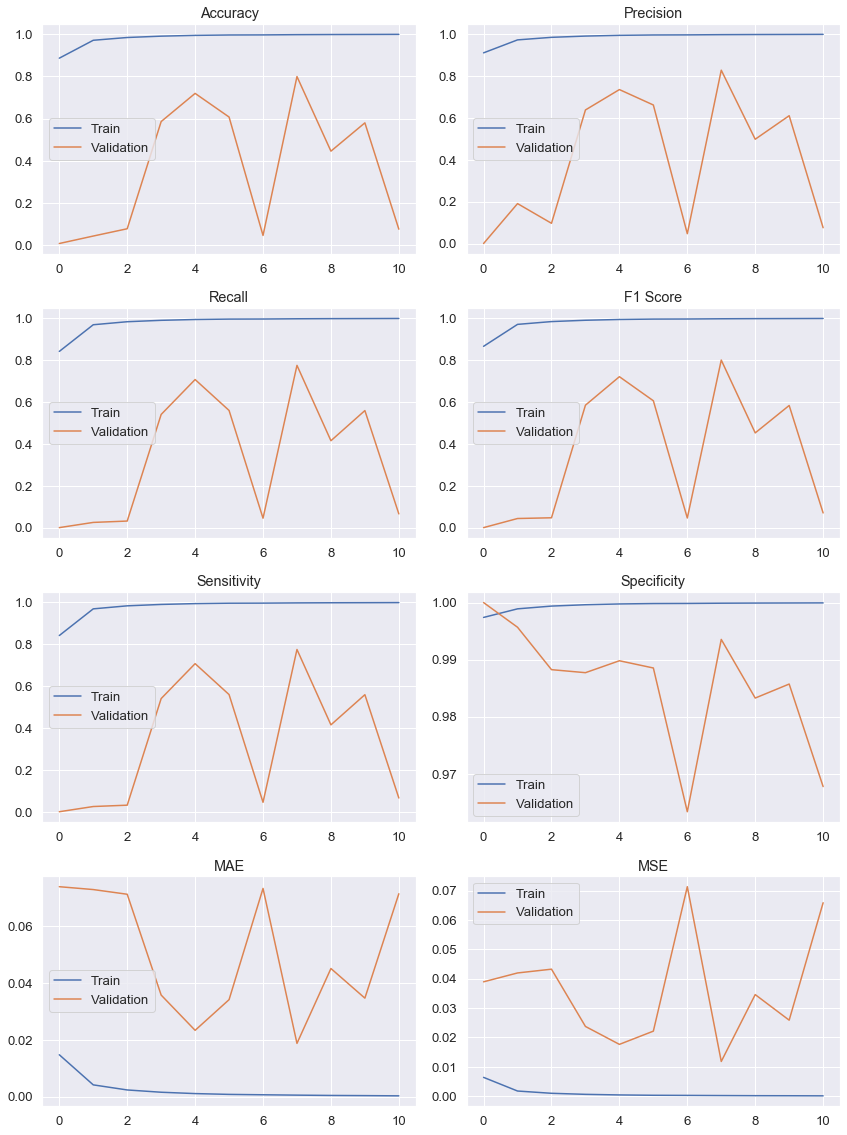

In [40]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
a4 = history.history['accuracy'][-1]
f4 = history.history['f1_score'][-1]
p4 = history.history['precision_m'][-1]
r4 = history.history['recall_m'][-1]
mae4 = history.history['mae'][-1]
mse4 = history.history['mse'][-1]
specificity4 = history.history['specificity_m'][-1]  
sensitivity4 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a4 * 100))
print('Precision = ' + str(p4 * 100))
print('F1 Score = ' + str(f4 * 100))
print('Recall = ' + str(r4 * 100))
print('MAE = ' + str(mae4))
print('MSE = ' + str(mse4))
print('Sensitivity = ' + str(sensitivity4 * 100))  
print('Specificity = ' + str(specificity4 * 100))

Accuracy = 99.8567283153534
Precision = 99.85960125923157
F1 Score = 99.85571503639221
Recall = 99.8519241809845
MAE = 0.0003009042120538652
MSE = 8.767905819695443e-05
Sensitivity = 99.8519241809845
Specificity = 99.99449253082275


407/407 [==============================] - 41s 101ms/step - loss: 546319.8750 - accuracy: 0.0768 - f1_score: 0.0699 - recall_m: 0.0655 - precision_m: 0.0751 - specificity_m: 0.9677 - sensitivity_m: 0.0655 - mae: 0.0714 - mse: 0.06597s - loss: 543490.3125 - accuracy: 0.0766 - f1_score: 0.0699 - recall_m: 0.0654 - precision_m: 0.0


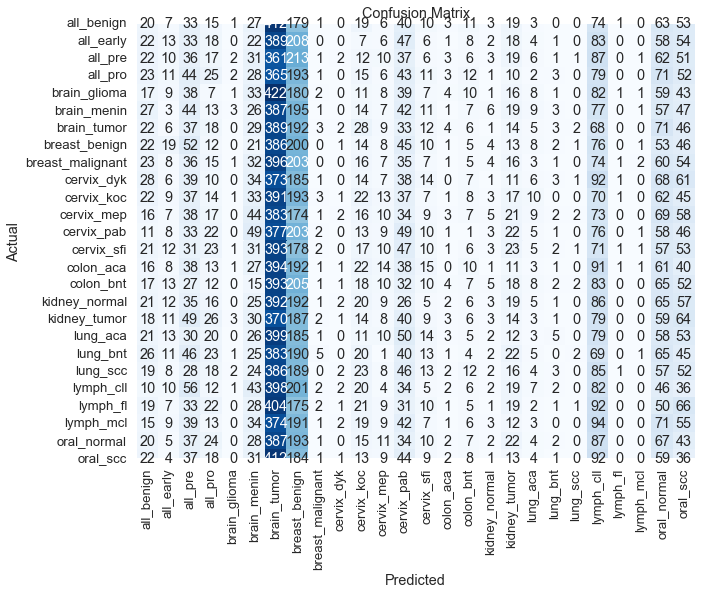

In [42]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

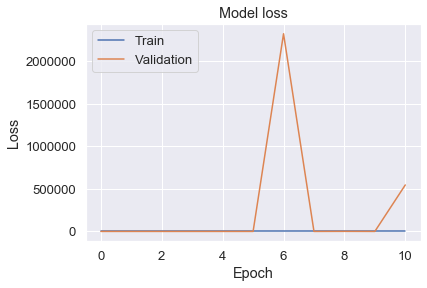

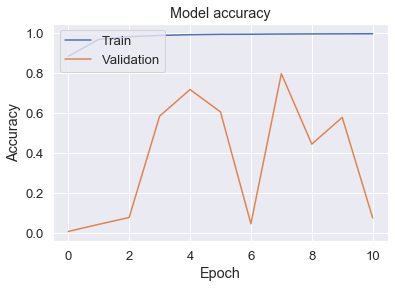

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Extension

# Xception

In [44]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [45]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(26, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [46]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m,mae,mse])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(train_gen, epochs=100, batch_size=batch_size, validation_data=val_gen, callbacks=[early_stopping_callback])

Epoch 1/100
1625/1625 [==============================] - 477s 292ms/step - loss: 0.1867 - accuracy: 0.9350 - f1_score: 0.9336 - recall_m: 0.9268 - precision_m: 0.9417 - specificity_m: 0.9978 - sensitivity_m: 0.9268 - mae: 0.0070 - mse: 0.0037 - val_loss: 0.2798 - val_accuracy: 0.9161 - val_f1_score: 0.9159 - val_recall_m: 0.9136 - val_precision_m: 0.9182 - val_specificity_m: 0.9967 - val_sensitivity_m: 0.9136 - val_mae: 0.0076 - val_mse: 0.0052
Epoch 2/100
1625/1625 [==============================] - 473s 291ms/step - loss: 0.0761 - accuracy: 0.9745 - f1_score: 0.9745 - recall_m: 0.9733 - precision_m: 0.9758 - specificity_m: 0.9990 - sensitivity_m: 0.9733 - mae: 0.0029 - mse: 0.0015 - val_loss: 0.1056 - val_accuracy: 0.9653 - val_f1_score: 0.9652 - val_recall_m: 0.9640 - val_precision_m: 0.9663 - val_specificity_m: 0.9987 - val_sensitivity_m: 0.9640 - val_mae: 0.0035 - val_mse: 0.0021
Epoch 3/100
1625/1625 [==============================] - 476s 293ms/step - loss: 0.0530 - accuracy: 0.

In [47]:
model.save('models/xception.h5')

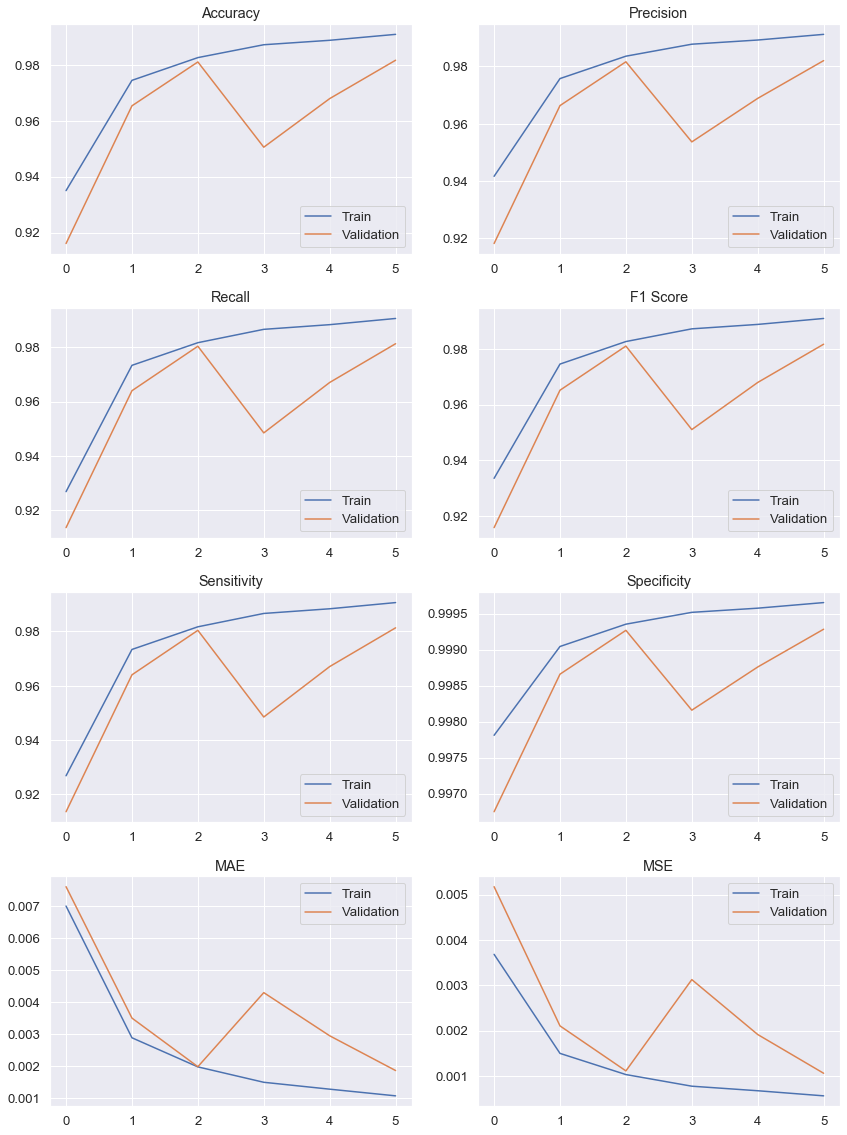

In [48]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

407/407 [==============================] - 42s 103ms/step - loss: 0.0545 - accuracy: 0.9817 - f1_score: 0.9817 - recall_m: 0.9813 - precision_m: 0.9820 - specificity_m: 0.9993 - sensitivity_m: 0.9813 - mae: 0.0019 - mse: 0.0011


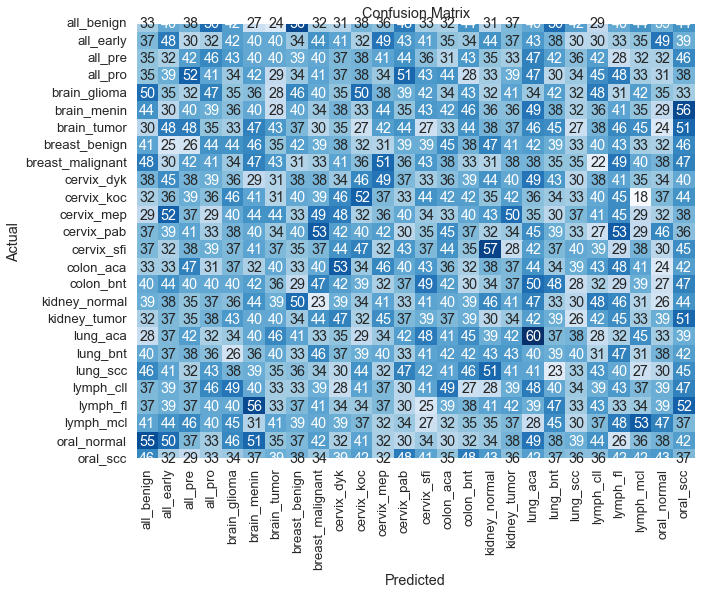

In [49]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
a5 = history.history['accuracy'][-1]
f5 = history.history['f1_score'][-1]
p5 = history.history['precision_m'][-1]
r5 = history.history['recall_m'][-1]
mae5 = history.history['mae'][-1]
mse5 = history.history['mse'][-1]
specificity5 = history.history['specificity_m'][-1]  
sensitivity5 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a5 * 100))
print('Precision = ' + str(p5 * 100))
print('F1 Score = ' + str(f5 * 100))
print('Recall = ' + str(r5 * 100))
print('MAE = ' + str(mae5))
print('MSE = ' + str(mse5))
print('Sensitivity = ' + str(sensitivity5 * 100))  
print('Specificity = ' + str(specificity5 * 100))

Accuracy = 99.0913450717926
Precision = 99.11847114562988
F1 Score = 99.08870458602905
Recall = 99.05961751937866
MAE = 0.0010764950420707464
MSE = 0.0005582200246863067
Sensitivity = 99.05961751937866
Specificity = 99.96534585952759


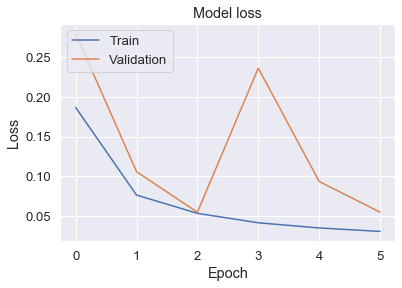

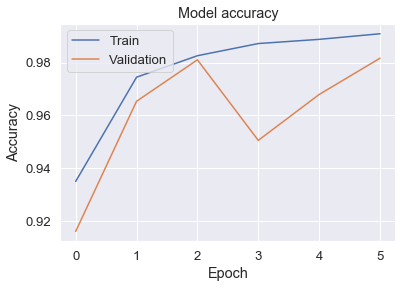

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Comparison

In [52]:

results = {
    'Accuracy': [a, a1, a2, a3, a4,a5],
    'Recall': [r, r1, r2, r3, r4,r5],
    'Precision': [p, p1, p2, p3, p4,p5],
    'F1': [f, f1, f2, f3, f4,f5],
    'MAE': [mae, mae1, mae2, mae3, mae4,mae5],
    'MSE': [mse, mse1, mse2, mse3, mse4,mse5],
    'Specificity': [specificity, specificity1, specificity2, specificity3, specificity4, specificity5],
    'Sensitivity': [sensitivity, sensitivity1, sensitivity2, sensitivity3, sensitivity4, sensitivity4]
}

index = ['VGG16', 'VGG19', 'DenseNet201', 'MobileNetV3-Small', 'MobileNetV3-Large','Xception']

In [53]:
results =pd.DataFrame(results,index=index)

In [54]:
print(results)

                   Accuracy    Recall  Precision        F1  \
VGG16              0.995106  0.994683   0.995438  0.995056   
VGG19              0.952413  0.950212   0.955314  0.952731   
DenseNet201        0.988096  0.987721   0.988424  0.988069   
MobileNetV3-Small  0.995827  0.995769   0.995942  0.995855   
MobileNetV3-Large  0.998567  0.998519   0.998596  0.998557   
Xception           0.990913  0.990596   0.991185  0.990887   

                                                    MAE  \
VGG16              <function mae at 0x000001A25B1E01F8>   
VGG19                                          0.004552   
DenseNet201                                    0.001422   
MobileNetV3-Small                              0.000482   
MobileNetV3-Large                              0.000301   
Xception                                       0.001076   

                                                    MSE  Specificity  \
VGG16              <function mse at 0x000001A25B1E0708>     0.999821   
VGG19  

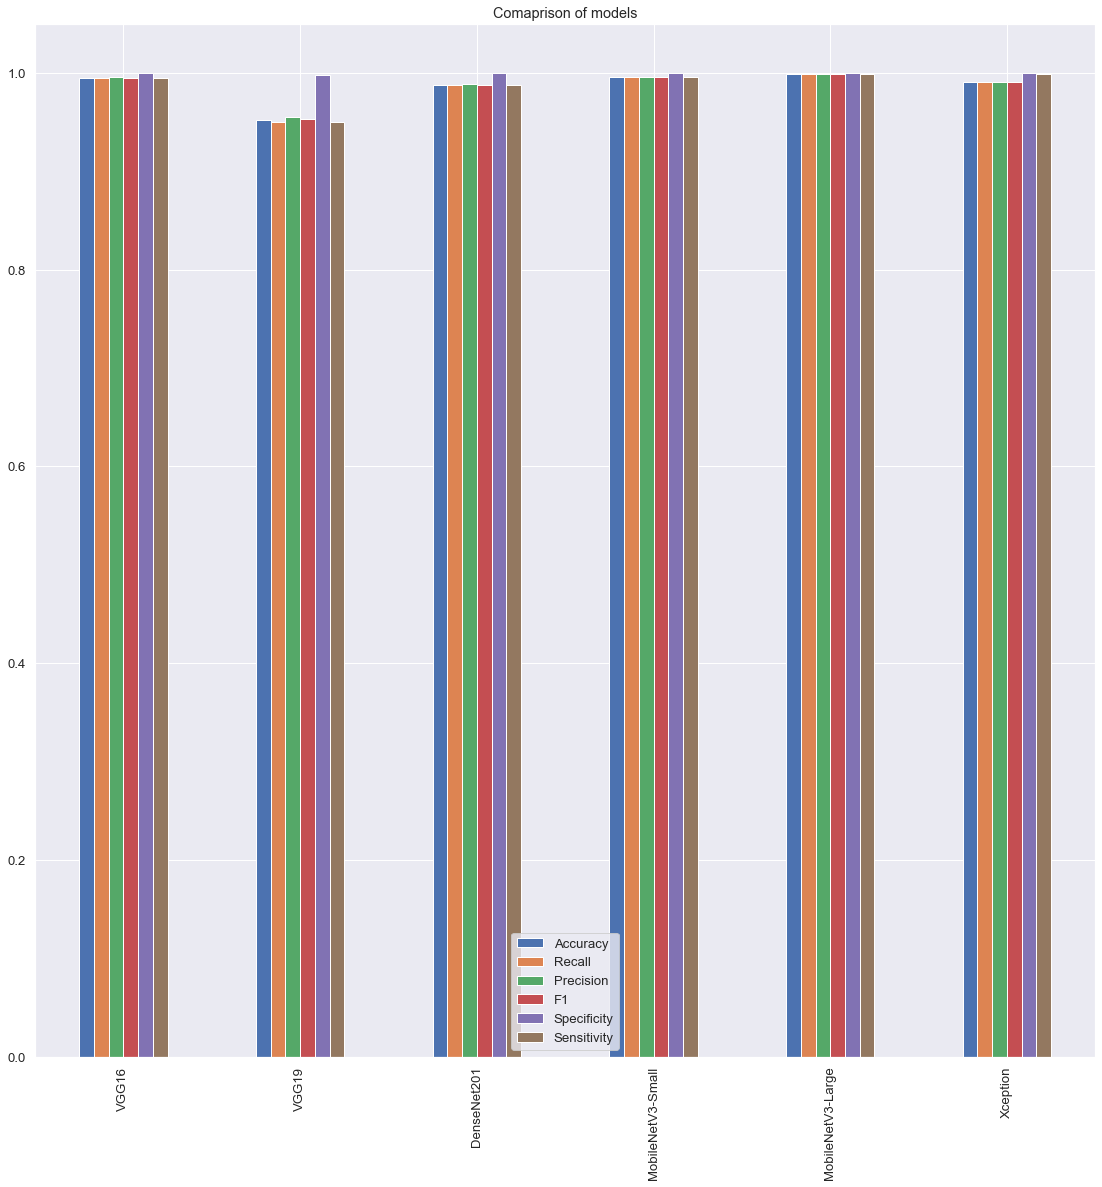

In [55]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A170163948>,
      dtype=object)

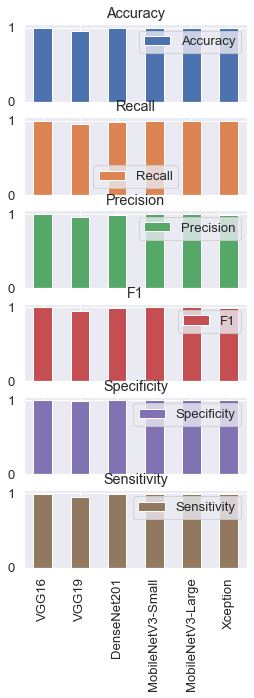

In [56]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))

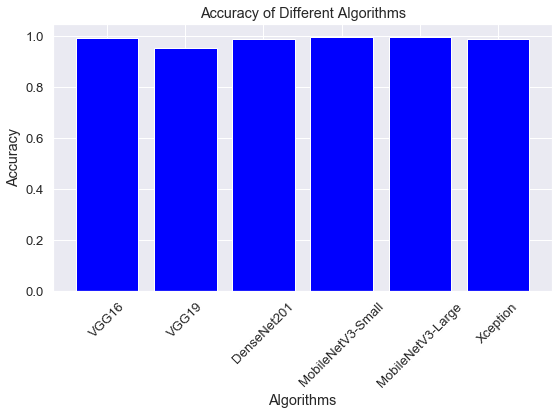

In [57]:
accuracy_values = results['Accuracy']
accuracy_df = pd.DataFrame({'Algorithms': index, 'Accuracy': accuracy_values})

plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Algorithms'], accuracy_df['Accuracy'], color='blue')
plt.title('Accuracy of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

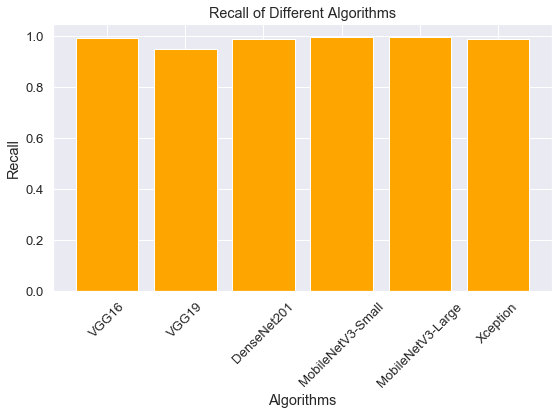

In [58]:
recall_values = results['Recall']
recall_df = pd.DataFrame({'Algorithms': index, 'Recall': recall_values})

plt.figure(figsize=(8, 6))
plt.bar(recall_df['Algorithms'], recall_df['Recall'], color='orange')
plt.title('Recall of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

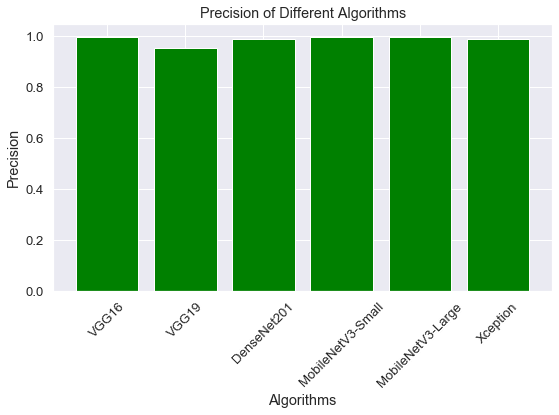

In [59]:
precision_values = results['Precision']
precision_df = pd.DataFrame({'Algorithms': index, 'Precision': precision_values})

plt.figure(figsize=(8, 6))
plt.bar(precision_df['Algorithms'], precision_df['Precision'], color='green')
plt.title('Precision of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

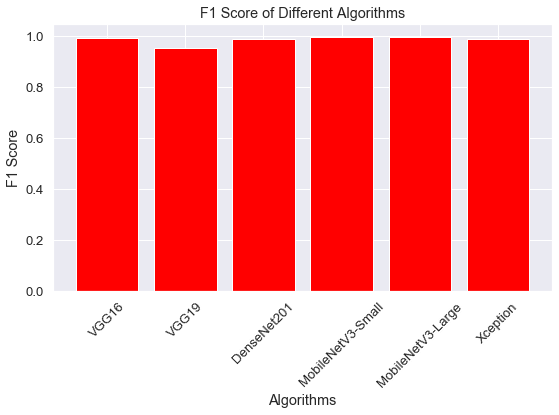

In [60]:
f1_values = results['F1']
f1_df = pd.DataFrame({'Algorithms': index, 'F1 Score': f1_values})

plt.figure(figsize=(8, 6))
plt.bar(f1_df['Algorithms'], f1_df['F1 Score'], color='red')
plt.title('F1 Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()